In [1]:
# Utils
# ==============================================================================
import warnings

# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
# ==============================================================================
from unicodedata import normalize
import pandas as pd
import numpy as np

## Model
# ==============================================================================
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest


# **Info**
---

**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr

# **Objective**
---

Isolation Forest Implementations

# **Config**
---

In [2]:
random_seed = 12354
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
pd.set_option('display.float_format', '{:,.2f}'.format)
paleta = {
    'REGALIAS': '#66c2a5',
    'COMPENSACIÓN': '#fc8d62',
    -1: '#e41a1c',
    1: '#377eb8'
}
np.set_printoptions(precision=3, suppress=True)

In [3]:
sns.color_palette('Set1').as_hex()

['#e41a1c',
 '#377eb8',
 '#4daf4a',
 '#984ea3',
 '#ff7f00',
 '#ffff33',
 '#a65628',
 '#f781bf',
 '#999999']

# **Utils**
---

In [4]:
def normalize_word(word):
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

# **DATA**
---

In [5]:
url_mining_materials = 'https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'
url_mining_materials = 'https://drive.google.com/uc?id=' + url_mining_materials.split('/')[-2]
data_mining_materials = pd.read_csv(url_mining_materials, dtype='str')

Normalization of column names

In [6]:
data_mining_materials.columns = normalize_name_columns(
    data_mining_materials.columns)
data_mining_materials.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

The appropriate data types were assigned to the data.

In [7]:
data_mining_materials[[
    'valor_contraprestacion',
    'cantidad_produccion'
]] = data_mining_materials[[
    'valor_contraprestacion',
    'cantidad_produccion'
]].astype('float64')

The data type of the "trimestre" (quarter) column was changed from text to numeric.

In [8]:
data_mining_materials[
    'trimestre'] = data_mining_materials[
        'trimestre'].apply(lambda x: x.split(' ')[1])

data_mining_materials.head(3)

,municipio_productor,departamento,recurso_natural,nombre_del_proyecto,ano_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,4,TONELADAS,REGALIAS,"614,258.00",0.00
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,4,TONELADAS,REGALIAS,"2,036,781.00","14,381.00"
2,Medellin,Antioquia,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,1,TONELADAS,REGALIAS,"836,927.00","16,308.00"


In [9]:
data_mining_materials[[
    'trimestre',
    'ano_produccion'
]] = data_mining_materials[[
    'trimestre',
    'ano_produccion'
]].astype('int32')

The model was trained using data spanning a 5-year period.

In [10]:
data_mining_materials = data_mining_materials[
    (data_mining_materials["ano_produccion"] >= 2018)
    &
    (data_mining_materials["ano_produccion"] < 2023)
    ]

Municipality and department were combined to create unique records, since different municipalities can have the same name in different departments

In [11]:
data_mining_materials['key'] = data_mining_materials.municipio_productor.str.cat(
    data_mining_materials.departamento, sep='-')

The data was grouped by 'key', 'ano_produccion' (year of production), 'trimestre' (quarter), and 'tipo_contraprestacion' (type of compensation) to obtain the "valor_contraprestacion" (compensation value) and the number of transactions by year, quarter, and type of compensation.

In [12]:
function_dictionary = {
    "valor_contraprestacion": ['sum', 'count']
}

filter_feature = [
    'key',
    'ano_produccion',
    'trimestre',
    'tipo_contraprestacion'
    ]
new_val_col = [
    'valor_contraprestacion',
    'conteo_transacciones'
]

data_group = data_mining_materials.groupby(
    filter_feature
).aggregate(function_dictionary)

data_group.columns = new_val_col
data_group = data_group.reset_index()

data_group.head()

,key,ano_produccion,trimestre,tipo_contraprestacion,valor_contraprestacion,conteo_transacciones
0,Abejorral-Antioquia,2018,1,REGALIAS,"2,783,489.00",1
1,Abejorral-Antioquia,2018,2,REGALIAS,"3,659,452.00",1
2,Abejorral-Antioquia,2018,3,REGALIAS,"5,732,763.00",1
3,Abejorral-Antioquia,2018,4,REGALIAS,"11,706,438.00",2
4,Abejorral-Antioquia,2019,1,REGALIAS,"5,793,131.00",2


In [13]:
function_dictionary = {
    "valor_contraprestacion": ['sum'],
    "conteo_transacciones": ['sum'],
    'trimestre': ['count'],
}

filter_feature = [
    'key',
    'tipo_contraprestacion']



data_group2 = data_group.groupby(
    filter_feature).aggregate(function_dictionary)

new_val_col = [
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos',
]


data_group2.columns = new_val_col
data_group2 = data_group2.reset_index()

data_group2.head()

,key,tipo_contraprestacion,valor_contraprestacion,numero_transacciones,numero_trimestres_activos
0,Abejorral-Antioquia,REGALIAS,"52,580,674.00",17,11
1,Abrego-Norte de Santander,REGALIAS,"22,530,021.00",21,16
2,Abriaqui-Antioquia,REGALIAS,"355,266,722.00",35,15
3,Acacias-Meta,REGALIAS,"607,849,192.00",58,20
4,Achi-Bolivar,REGALIAS,"557,468,046.00",6,3


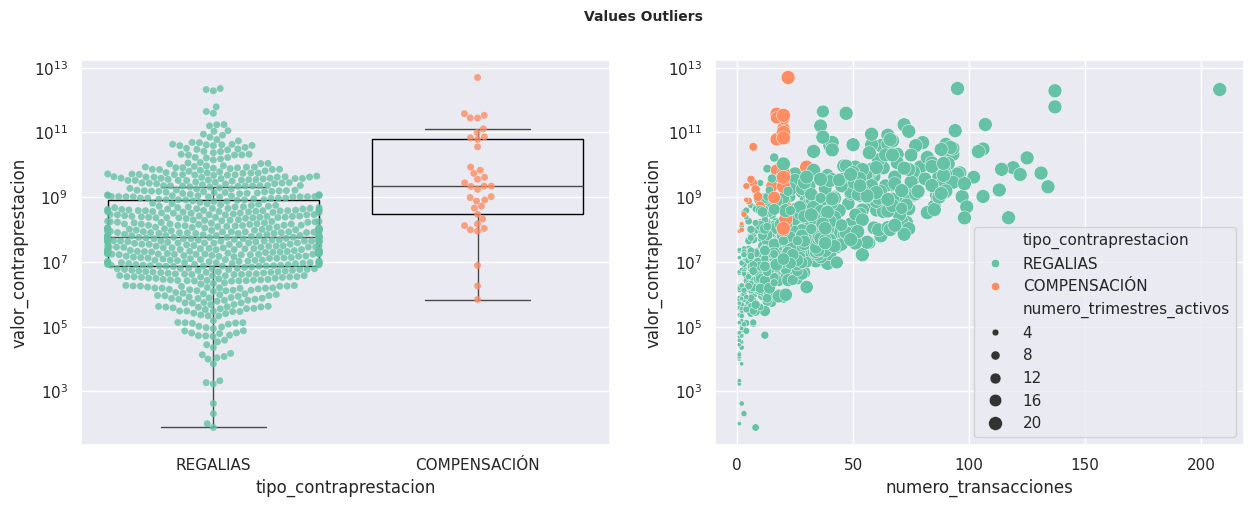

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.swarmplot(
    data=data_group2,
    y="valor_contraprestacion",
    x='tipo_contraprestacion',
    ax=ax[0],
    palette=paleta,
    alpha=0.8
)
sns.boxplot(
    data=data_group2,
    y='valor_contraprestacion',
    x='tipo_contraprestacion',
    ax=ax[0],
    boxprops=dict(facecolor='none', edgecolor='black'),
    flierprops=dict(marker=''),
    palette=paleta)
ax[0].set(yscale="log")

sns.scatterplot(
    data= data_group2,
    x="numero_transacciones",
    y="valor_contraprestacion",
    size = 'numero_trimestres_activos',
    sizes =(10, 100),
    ax=ax[1],
    hue='tipo_contraprestacion', palette=paleta)
ax[1].set(yscale="log")

fig.suptitle('Values Outliers', fontsize = 10, fontweight = "bold");
plt.show()

- Royalties show a negative bias and a high concentration of records with amounts between 10,000,000 and 1,000,000,000 in the amount paid. A high concentration of transactions within the range of 40 to 80 during the activity period is also observed. A large number of outliers is also observed

- An imbalance is noted in the number of records between Royalties and Compensation.

- Compensation also shows a negative bias and a greater dispersion in the amounts paid, ranging between 100,000,000 and 10,000,000,000. A high concentration of transactions is also observed within the range of 5 to 25 during the activity period, which is lower than in the case of royalties. This suggests that compensations may involve fewer transactions but with significantly higher amounts, compared to royalties. Outliers are also evident.

# **Multivariate Anomaly Model**
---




The data was divided by transaction type. Although this variable will not be used — only the quantitative ones — it may still influence the identification of outliers due to the significant imbalance. This is because all compensation records could be considered outliers, as they are the only ones showing activity under this type of transaction, in contrast to royalties.

In [15]:
data_group2_regalias = data_group2[data_group2['tipo_contraprestacion'] == 'REGALIAS']
data_group2_compensacion = data_group2[data_group2['tipo_contraprestacion'] == 'COMPENSACIÓN']

Two IsolationForest models were implemented for each type of transaction, using 100 estimators, a contamination rate of 15%, and all the data applying bootstrapping.

In [16]:
model_aoutliers_regalias = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.15,
    bootstrap=True,
    random_state = random_seed,
    verbose=0,
    n_jobs=-1,
)

model_group2_compensacion = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.15,
    bootstrap=True,
    random_state = random_seed,
    verbose=0,
    n_jobs=-1,
)

model_aoutliers_regalias.fit(data_group2_regalias[[
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos']])


model_group2_compensacion.fit(data_group2_compensacion[[
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos']])

IsolationForest(bootstrap=True, contamination=0.15, n_jobs=-1,
                random_state=12354)

A total of 106 outliers were detected out of 706 royalty records.

In [17]:
y_predict = model_aoutliers_regalias.predict(X=data_group2_regalias[[
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos']])
data_group2_regalias['aoutliers'] = y_predict

In [18]:
data_group2_regalias['aoutliers'].value_counts()

,count
aoutliers,
1,600
-1,106


A total of 6 outliers were detected out of 31 compensation records

In [19]:
y_predict = model_group2_compensacion.predict(X=data_group2_compensacion[[
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos']])
data_group2_compensacion['aoutliers'] = y_predict

In [20]:
data_group2_compensacion['aoutliers'].value_counts()

,count
aoutliers,
1,31
-1,6


In [21]:
data_merge = pd.concat([data_group2_regalias, data_group2_compensacion], axis=0)
data_merge

,key,tipo_contraprestacion,valor_contraprestacion,numero_transacciones,numero_trimestres_activos,aoutliers
0,Abejorral-Antioquia,REGALIAS,"52,580,674.00",17,11,1
1,Abrego-Norte de Santander,REGALIAS,"22,530,021.00",21,16,1
2,Abriaqui-Antioquia,REGALIAS,"355,266,722.00",35,15,1
3,Acacias-Meta,REGALIAS,"607,849,192.00",58,20,1
4,Achi-Bolivar,REGALIAS,"557,468,046.00",6,3,-1
...,...,...,...,...,...,...
656,Tibasosa-Boyaca,COMPENSACIÓN,"212,059,238.00",21,20,1
716,Villanueva - Santander-Santander,COMPENSACIÓN,"976,911,933.00",16,16,1
732,Yumbo-Valle del Cauca,COMPENSACIÓN,"109,142,566.00",20,20,1
735,Zapatoca-Santander,COMPENSACIÓN,"1,043,404,222.00",9,9,1


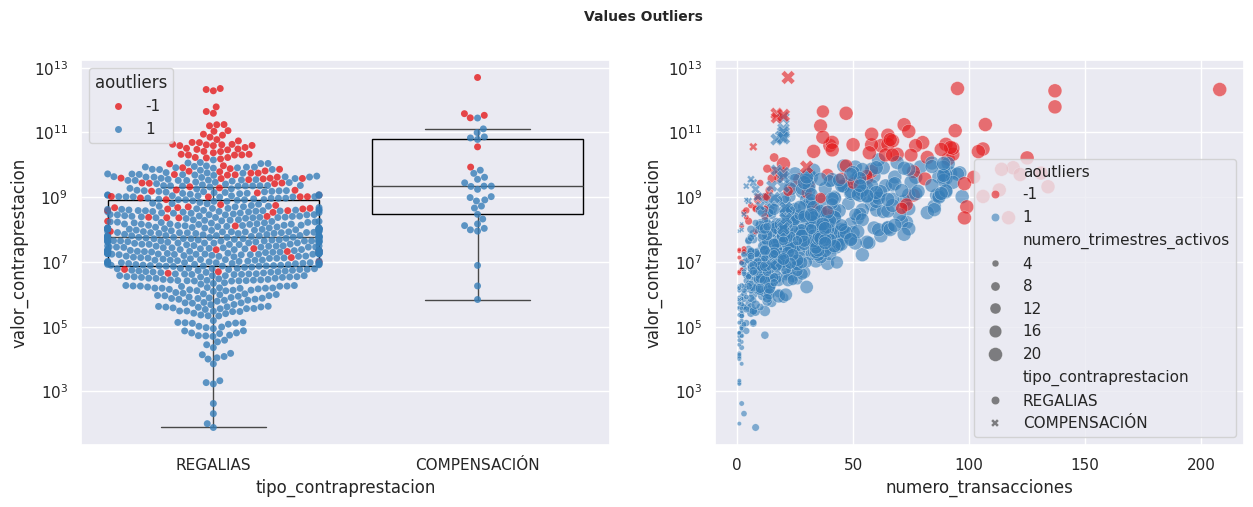

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.swarmplot(
    data=data_merge,
    y="valor_contraprestacion",
    x='tipo_contraprestacion',
    ax=ax[0],
    palette=paleta,
    hue='aoutliers',
    alpha=0.8
)
sns.boxplot(
    data=data_merge,
    y='valor_contraprestacion',
    x='tipo_contraprestacion',
    ax=ax[0],
    boxprops=dict(facecolor='none', edgecolor='black'),
    flierprops=dict(marker=''),
    palette=paleta)
ax[0].set(yscale="log")

sns.scatterplot(
    data= data_merge,
    x="numero_transacciones",
    y="valor_contraprestacion",
    ax=ax[1],
    size='numero_trimestres_activos',
    sizes =(10, 100),
    hue='aoutliers',
    palette=paleta,
    style='tipo_contraprestacion',
    #markers = {"REGALIAS":'x', 'COMPENSACIÓN':'o'},
    alpha=0.6)
ax[1].set(yscale="log")

fig.suptitle('Values Outliers', fontsize = 10, fontweight = "bold");
plt.show()

- Several outliers can be observed in the transaction types. What is interesting in the first graph is that the outliers are not necessarily above the upper limit of the box plot. What happens is that this graph only measures the variable 'valor_contraprestacion'

- The second graph provides more information. Some cases can be observed, such as:
  - Compensations with few transactions, but with a high amount.
  - Compensations with multiple transactions and a high amount.
  - Royalties with high amounts, but with few transactions.
  - Royalties with high amounts and many transactions.

The 10th quintile was calculated within the scores to determine the threshold for identifying which records are anomalies. The score in Isolation Forest is a measure proportional to the average path length required to isolate an observation within a set of random trees. Observations that are isolated with fewer splits (shorter path length) receive lower scores and are considered more anomalous; the more negative the score, the more likely the observation is an outlier.

In [23]:
score_anomalia  = model_aoutliers_regalias.score_samples(
    X=data_group2_regalias[[
        'valor_contraprestacion',
        'numero_transacciones',
        'numero_trimestres_activos']])

np.quantile(score_anomalia, q=0.05)

np.float64(-0.5689587000199339)

It is possible to use the level of contamination as a threshold.


In [25]:
np.quantile(score_anomalia, q=model_aoutliers_regalias.contamination)

np.float64(-0.4922763428181746)

In [26]:
model_aoutliers_regalias.offset_

np.float64(-0.4922763428181746)

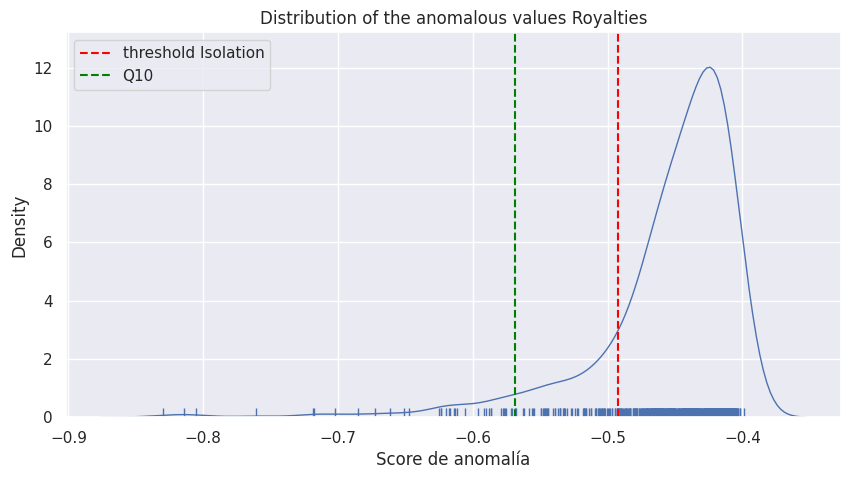

In [32]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.distplot(
    score_anomalia,
    hist    = False,
    rug     = True,
    color   = 'b',
    kde_kws = {'shade': False, 'linewidth': 1},
    ax      = ax
)

ax.axvline(model_aoutliers_regalias.offset_, c='red', linestyle='--', label='threshold Isolation')
ax.axvline(np.quantile(score_anomalia, q=0.05), c='green', linestyle='--', label="Q10")
ax.set_title('Distribution of the anomalous values Royalties')
ax.set_xlabel('Score de anomalía');
ax.legend()


- The density shows how many points have a given value in the anomaly score. In other words, the number of points with a given score.
- The red vertical line indicates the threshold for classifying points as anomalous or normal.
- Points located to the left of this line are considered anomalies, while points to the right of it are considered within the expected range.
- A high concentration of points is observed to the right of the red line, which suggests that most of the data is not anomalous and falls within the expected behavior
- The left skew (with lower scores) shows that there are some points considered anomalous, but they are few compared to the normal ones.

- The threshold to consider is very rigid, as it classifies records that, although they deviate from the concentration (the so-called borderline records), as atypical, even though they may fall within what is possible

- Using the anomaly scores, and considering that the most negative scores correspond to potential outliers, these observations are expected to be concentrated on the left side of the distribution. Therefore, a 10th percentile threshold was defined to identify anomalies, providing a more reasonable cutoff while excluding borderline cases. This can be better observed through the green line, which moves away from the main concentration of the data and is positioned further in the tail of the distribution.

In [34]:
score_anomalia  = model_group2_compensacion.score_samples(
    X=data_group2_compensacion[[
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos']])

np.quantile(score_anomalia, q=0.05)

np.float64(-0.609541720048228)

In [35]:
np.quantile(score_anomalia, q=model_group2_compensacion.contamination)

np.float64(-0.5833890542259353)

In [36]:
model_group2_compensacion.offset_

np.float64(-0.5833890542259353)

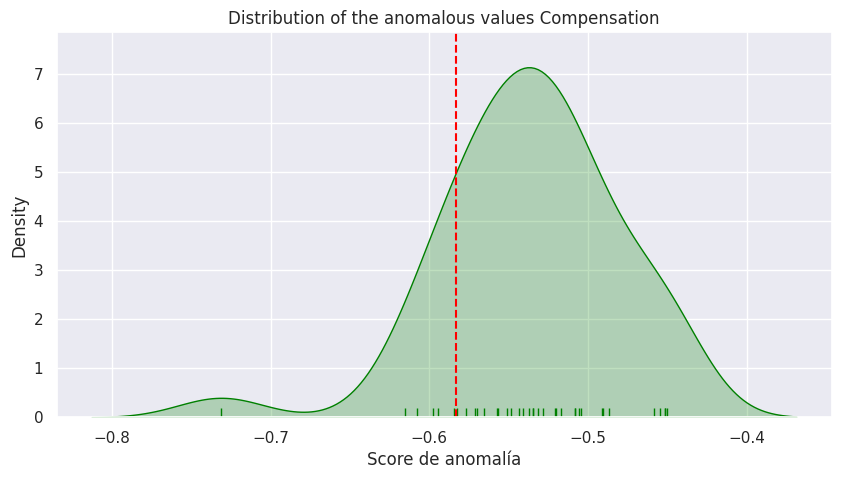

In [37]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.distplot(
    score_anomalia,
    hist    = False,
    rug     = True,
    color   = 'green',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.axvline(model_group2_compensacion.offset_, c='red', linestyle='--')
ax.set_title('Distribution of the anomalous values Compensation')
ax.set_xlabel('Score de anomalía');


-  The density shows how many points have a given value in the anomaly score. In other words, the number of points with a given score.
- The red vertical line indicates the threshold for classifying points as anomalous or normal.
- Points located to the left of this line are considered anomalies, while points to the right of it are considered within the expected range.

- There is a concentration of points to the right of the red line, which would be the normal data, although somewhat dispersed, the data has more variables.

- It has very dispersed data, located below the threshold (red line). There are some points that could be considered borderline points, possibly not anomalous. It is necessary to reevaluate the degree of contamination to a smaller value.

# **Info**
---


**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr